# Spinning Cheetah

In this example, we will implement the [MPPI](https://arxiv.org/pdf/1909.11652.pdf) planner with ground truth dynamics to break the MuJoCo simulator.
Unfortunately, this means that a running MuJoCo installation is required. If you do not have one, you can still look at the implementation, but you just have to trust the data.

The basic steps of <b>MPPI</b> include:

1. generate action sequences with correlated Gaussian noise.
2. compute the reward for each sequence.
3. reweight the actions and calculate their mean value.

Depending on the given horizon, the planner can output multiple steps. However, replanning after each step results in better performance.

In [12]:
from IPython import display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
from copy import deepcopy
import gym

ENV_NAME = "HalfCheetah-v2"

# Calculate the cumulative reward for the 

In `MBRL-Lib` most algorithms including [PETS](https://arxiv.org/pdf/1805.12114.pdf) and 
[MBPO](https://github.com/JannerM/mbpo/blob/master/mbpo/static/halfcheetah.py) learn the dynamics of the 
environment using ensemble networks. We will take a shortcut and simply use the real dynamics provided by MuJoCo. The following function simply reloads a given state, executes the actions from `act_sequences`, and
computes the total accumulated reward.

In [13]:
def calc_reward_mujoco(state, act_sequences):

    # act_sequences are of the form (N, H, A), where N, H, A are the batch size,
    # horizon, and action dimension, respectively.

    env = gym.make(ENV_NAME)
    env.reset()
    rews = np.zeros(len(act_sequences))

    for i in range(len(act_sequences)):
        env.unwrapped.sim.set_state(state)

        for h in range(act_sequences.shape[1]):
            (observation, reward, done, info) = \
                env.step(act_sequences[i, h, :])
            rews[i] += reward

    return rews


# MPPI

The general idea of MPPI is to generate actions with correlated noise. This both produces smoother rollouts
and reduces effective degree of freedome in the search space. The noise samples are generated by using  
filtering coefficient $\beta$.

\begin{equation*}
u^i_t \thicksim \mathcal{N}(0, \Sigma), i \in \{0,.., N-1\}, t \in \{0,..,H-1\} \\
n^i_t = \beta u^i_t + (1-\beta)n^i_{t-1}
\end{equation*}

Here $H$ is the Horizon and $N$ is the population size.
This procedure is often used in running averages. After computing the reward $R$ we reweight the actions with

\begin{equation*}
\mu_t = \frac{\sum_{k=0}^{N}(e^{\gamma R_k})a^{(k)}_t}{\sum_{j=0}^N e^{\gamma R_j}}
\end{equation*}

where $\gamma$ is weight factor. Combining both we yield our general update formula for the action
which we can implement.

\begin{equation*}
a^i_t = \beta(u^i_t + \mu_t) + (1-\beta)(u^i_{t-1} + \mu_{t-1})
\end{equation*}

Since the action space for the `HalfCHeetah` task is between -1 and 1 we will use truncated noise to avoid
large amount of particles at the boundery. This is similar to the `CEM` implementation in `MBRL-Lib`. The
update rules described above can be performed multiple times to refine actions.

In [14]:
class MPPI:

    def __init__(
        self,
        population,
        horizon,
        num_iter,
        rew_weight,
        beta,
        noise_magnifier,
        act_dim,
        ):

        self.act_dim = act_dim
        self.horizon = horizon
        self.rew_weight = rew_weight
        self.beta = beta
        self.var = noise_magnifier ** 2 * np.ones((horizon, act_dim))  # convert to variance
        self.sample_amount = horizon * population * self.act_dim
        self.population = population
        self.means = np.zeros((horizon, self.act_dim))
        self.num_iter = num_iter

    def __call__(self, state):
        past_action = self.means[0]
        self.means[:-1] = self.means[1:]

        for i in range(self.num_iter):
            noise = truncnorm.rvs(-2, 2,
                                  size=self.sample_amount).reshape((self.population,
                    self.horizon, self.act_dim))

            lower_bound_dist = self.means + 1  # for Cheetah the action bounderies are -1 and 1
            upper_bound_dist = 1 - self.means
            mv = np.minimum(np.sqrt(lower_bound_dist / 2),
                            np.sqrt(upper_bound_dist / 2))
            constrained_variance = np.minimum(mv, self.var)
            action_samples = np.copy(noise) * constrained_variance

            action_samples[:, 0, :] = self.beta * (self.means[0, :]
                    + noise[:, 0, :]) + (1 - self.beta) * past_action
            for i in range(max(self.horizon - 1, 0)):
                action_samples[:, i + 1, :] = self.beta * (self.means[i
                        + 1] + noise[:, i + 1, :]) + (1 - self.beta) \
                    * action_samples[:, i, :]

            action_samples = np.clip(action_samples, -1, 1)
            rews = calc_reward_mujoco(state, action_samples)
            weights = np.exp(self.rew_weight * (rews
                             - np.max(rews))).reshape(self.population,
                    1, 1)
            norm = np.sum(weights) + 1e-10
            weighted_actions = action_samples * weights
            self.means = np.sum(weighted_actions, axis=0) / norm
        return self.means[0]

# Benchmarking

First, we perform a single refinement step. This already gives already decent performance. Depending on the seed, this may already result in spinning behavior.

total reward:  7846.778294655258


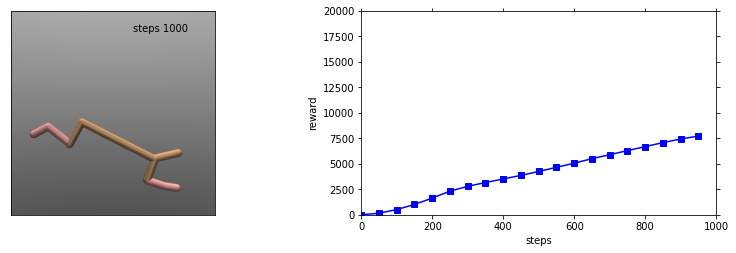

In [15]:
# setting up plotting

def update_axes(_axs, _frame, _text, _steps, _all_rewards):
    _axs[0].imshow(_frame)
    _axs[0].set_xticks([])
    _axs[0].set_yticks([])
    _axs[1].clear()
    _axs[1].set_xlim([0, 1000 + .1])
    _axs[1].set_ylim([0, 20000])
    _axs[1].set_xlabel("steps")
    _axs[1].set_ylabel("reward")
    _axs[1].plot([i*50 for i in range(len(_all_rewards))], _all_rewards, 'bs-')
    _text.set_text(f"steps {_steps + 1}")
    display.display(plt.gcf())  
    display.clear_output(wait=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(300, 50, "")
all_rewards = []

# setting up environment

env = gym.make(ENV_NAME)
env.reset()

# setting up MPPI

mppi = MPPI(
    population=700,
    horizon=20,
    num_iter=1,
    rew_weight=0.9,
    beta=0.9,
    noise_magnifier=0.9,
    act_dim=6)

# main loop .. this may take a while

total_reward = 0
mppi(env.unwrapped.sim.get_state())
for i in range(1000):
    act = mppi(env.unwrapped.sim.get_state())
    obs, rew, _, _ = env.step(act)
    total_reward += rew
    
    if i % 50 == 0:
        all_rewards.append(total_reward)
        
    update_axes(axs, env.render(mode="rgb_array"), ax_text, i, all_rewards)

update_axes(axs, env.render(mode="rgb_array"), ax_text, i, all_rewards)
print("total reward: ", total_reward)


# Breaking the Simulator

With five refinement steps, we usually break the simulation and get the classic Spinning Cheetah Run.
Again, there may be seeds where the spin is not observed.

MujocoException: Got MuJoCo Warning: Nan, Inf or huge value in QACC at DOF 0. The simulation is unstable. Time = 31.7800.

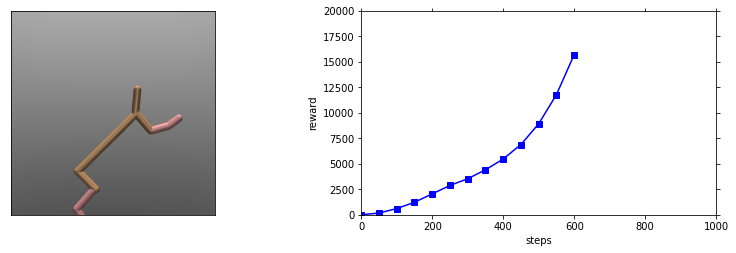

In [18]:
env.reset()
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
all_rewards = []
# setting up MPPI

mppi = MPPI(
    population=700,
    horizon=20,
    num_iter=5,
    rew_weight=0.9,
    beta=0.9,
    noise_magnifier=0.9,
    act_dim=6)

# main loop .. this may take even longer

total_reward = 0
mppi(env.unwrapped.sim.get_state())
for i in range(1000):
    act = mppi(env.unwrapped.sim.get_state())
    obs, rew, _, _ = env.step(act)
    total_reward += rew
    
    if i % 50 == 0:
        all_rewards.append(total_reward)
        
    update_axes(axs, env.render(mode="rgb_array"), ax_text, i, all_rewards)

update_axes(axs, env.render(mode="rgb_array"), ax_text, i, all_rewards)
print("total reward: ", total_reward) # this line should not be reached
